Competetion: https://www.kaggle.com/competitions/street-view-getting-started-with-julia

Data: https://www.kaggle.com/competitions/street-view-getting-started-with-julia/data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2

from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import image

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print("Completed")

/kaggle/input/street-view-getting-started-with-julia/trainLabels.csv
/kaggle/input/street-view-getting-started-with-julia/train.zip
/kaggle/input/street-view-getting-started-with-julia/sampleSubmission.csv
/kaggle/input/street-view-getting-started-with-julia/resizeData.py
/kaggle/input/street-view-getting-started-with-julia/trainResized.zip
/kaggle/input/street-view-getting-started-with-julia/test.zip
/kaggle/input/street-view-getting-started-with-julia/testResized.zip
/kaggle/input/street-view-getting-started-with-julia/source-code-files.zip
Completed


### **EN** Set rute into constants
### **ES** Se ponen las rutas de los archivos en constantes

In [ ]:
TEST_LABELS_RUTE = '/kaggle/input/street-view-getting-started-with-julia/trainLabels.csv'
TRAIN_IMG_DIR = '/kaggle/output/street-view-getting-started-with-julia/trainResized/'
TEST_IMG_DIR = '/kaggle/output/street-view-getting-started-with-julia/testResized/'
TRAIN_IMG_ZIP = '/kaggle/input/street-view-getting-started-with-julia/trainResized.zip'
TEST_IMG_ZIP = '/kaggle/input/street-view-getting-started-with-julia/testResized.zip'
BASE_DIR = '/kaggle/output/street-view-getting-started-with-julia/'

**EN** Create a function that allows us to extract and create a directory if it doesn't exist
**ES** Creamos una función que nos permita extraer datos y crear un directorio en caso de que no exista

In [ ]:
def data_ext(Dir, Zip):
    if not os.path.exists(Dir):
        os.makedirs(Dir)
    zip_ref = zipfile.ZipFile(Zip)
    zip_ref.extractall(BASE_DIR)
    zip_ref.close()

**EN** Function that we use later to see the characteristics of the data such as missing values (NaN), all of features and number, records and columns

**ES** Función que usamos más tarde para ver las características de los datos, como valores faltantes (NaN), todas las características y el número, registros y columnas.

In [ ]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []

    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)

    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    print(variable_desc)

# Import the datasets

**EN** We use pandas to import the csv file And .head to see a piece of the data

**ES** Usamos pandas para importar el archivo csv Y .head para ver una parte de los datos

In [ ]:
data_ext(TRAIN_IMG_DIR, TRAIN_IMG_ZIP) # Train data
data_ext(TEST_IMG_DIR, TEST_IMG_ZIP) # Test data

train_data = pd.read_csv(TEST_LABELS_RUTE)

In [ ]:
train_data.head()

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R


### Data visualization

**EN** Show general data of dataframe
**ES** Mostrar datos generales de el dataframe

In [ ]:
data_description(train_data)

Data description
Total number of records 6283
number of features 2


    Name    Type  Unique levels  Missing
0     ID   int64           6283        0
1  Class  object             62        0


In [ ]:
train_data['img'] = [TRAIN_IMG_DIR + str(id) + '.Bmp' for id in train_data['ID'].values]

In [ ]:
lab=[]
test=[]

for i in os.listdir(TEST_IMG_DIR):
    test.append(io.imread(TEST_IMG_DIR+i,as_gray=True))
    lab.append(i.split('.')[0])

In [ ]:
test_img=np.array([cv2.resize(image,(28,28)) for image in test])
test_img=test_img[:,:,:,np.newaxis]
test_img.shape

(6220, 28, 28, 1)

In [ ]:
X = train_data.drop("Class", axis = 1)
y = train_data["Class"]
print("Completed")

Completed


In [ ]:
label = train_data['Class']
unique_labels = list(set(label))

label_id = [unique_labels.index(l) for l in label]
label_id = np.array(label_id, dtype=np.float32)
train_data['label'] = label_id

In [ ]:
train_data.head()

,ID,Class,img,label
0,1,n,/kaggle/output/street-view-getting-started-wit...,38.0
1,2,8,/kaggle/output/street-view-getting-started-wit...,25.0
2,3,T,/kaggle/output/street-view-getting-started-wit...,47.0
3,4,I,/kaggle/output/street-view-getting-started-wit...,30.0
4,5,R,/kaggle/output/street-view-getting-started-wit...,10.0


In [ ]:
y.value_counts()

A    459
E    357
R    309
O    291
N    279
    ... 
v     23
8     21
Q     21
z     20
j     20
Name: Class, Length: 62, dtype: int64

<AxesSubplot:title={'center':'Number of items b in each category'}, xlabel='Characters', ylabel='Number of characters'>

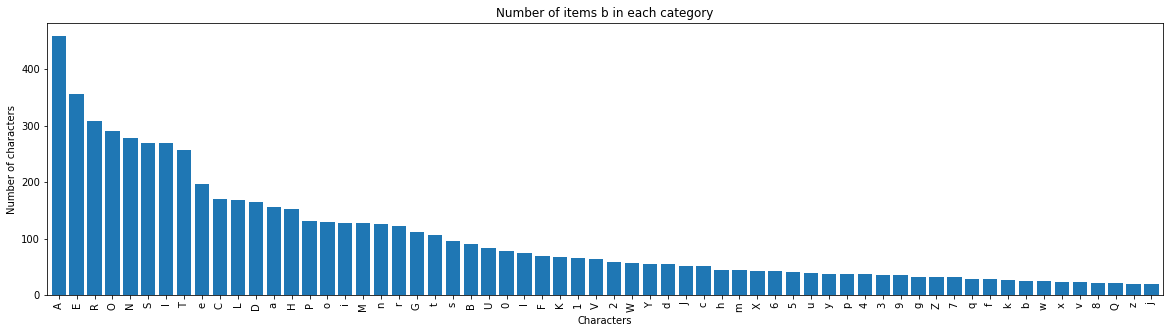

In [ ]:
result = y.value_counts()
plt.figure(figsize = (20, 5))
plt.title("Number of items b in each category")
plt.xlabel("Characters")
plt.ylabel("Number of characters")
result.plot.bar(width = 0.8)

**EN** As we can see, the difference with some characters is quite big
**ES** Como se puede ver hay una gran diferencia entre algunos caracteres

In [ ]:
X = X.drop("ID", axis = 1)

**EN** See the number of pixels in the image and the image number
**ES** Mirar el numero de pixeles de la imagen y el numero de imagenes disponibles

In [ ]:
print(f'Number of images: {X.shape[0]}\nNumer of pixels per image {X.shape[1]}')

Number of images: 6283
Numer of pixels per image 1


In [ ]:
X.head()

,img
0,/kaggle/output/street-view-getting-started-wit...
1,/kaggle/output/street-view-getting-started-wit...
2,/kaggle/output/street-view-getting-started-wit...
3,/kaggle/output/street-view-getting-started-wit...
4,/kaggle/output/street-view-getting-started-wit...


**EN** Change dir to image and separe this in pixels

**ES** Cambiar el directirio y poner la imagen separando los pixeles

In [ ]:
train_data_img = []
for img_path in train_data["img"]:
    img = image.imread(img_path)
    data = np.asarray(img)
    if data.shape != (20, 20, 3):
        data = np.repeat(data[:, :, np.newaxis], 3, axis=2)
    train_data_img.append(data)


img_data = np.asarray(train_data_img, dtype=np.uint8)
print("Completed")

Completed


In [ ]:
# final_train=[cv2.resize(image,(28,28)).flatten() for image in train_data_img]

In [ ]:
img_data.shape

(6283, 20, 20, 3)

In [ ]:
# See if the number of images its the same in X and in img_data
print(f"X: {X.shape[0]} size \nimg_data: {img_data.shape[0]} size")

X: 6283 size 
img_data: 6283 size


**EN** Show non modified img
**ES** Muestra las imagenes no modificadas

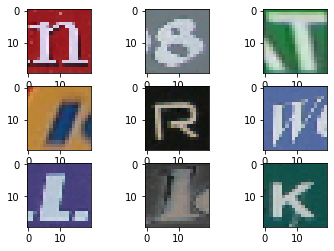

In [ ]:
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(img_data[i])

**EN** Create the data generaton

**ES** Creamos el creador de datos,

### Date generator

In [ ]:
datagen = ImageDataGenerator (
    zoom_range = 0.2,
    rescale = 1./255,
    rotation_range = 5.0,
    shear_range = 3.0,
    brightness_range = [0.0, 3.0]
)

In [ ]:
X = img_data
X = np.array(X).astype(float) / 255 # Normalize the data

y = np.array(train_data["label"])

In [ ]:
datagen.fit(X)
plt.figure(figsize = (20, 8))
datagen.flow(X, y, batch_size = 10, shuffle = False)

<Figure size 1440x576 with 0 Axes>

**EN** Show the "fake" data

**ES** Muestra los datos "falsos"

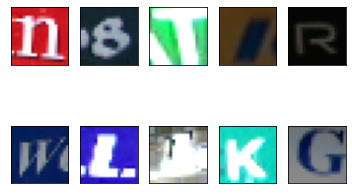

In [ ]:
for img, label in datagen.flow(X, y, batch_size = 10, shuffle = False):
    for i in range(10):
        plt.subplot(2,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img[i])
    break

### Training and validation split

**EN** Split of X and Y in training and validation data

**ES** División de **X** e **y** en datos de entrenamiento y validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0) # Test size = 25% of the data

**EN** Generate extra data, with latest parameters (datagen)

**ES** Generar datos extra mediante los anteriores parametros (datagen)

In [ ]:
data_gen_train = datagen.flow(X_train, y_train, batch_size = 20)

In [ ]:
num_pos = len(train_data["Class"].value_counts()) # Number of total posible results

### Model creation and fit

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(20,20,3)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(125, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_pos, activation='softmax')
])

print("Model created")


Model created


**EN** Compile the model

**ES** Compilar el modelo

In [ ]:
model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
print("Model compiled")

Model compiled


**EN** Create early stopping metod to imporve the model, the model stops if it sees that its performance is being lower during several epochs

**ES** Creamos un metodo *early stopping* para mejorar el modelo, el modelo para si ve que su desempeño esta siendo menor durante varias epocas

In [ ]:
es_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 10, monitor = "accuracy")]

**EN** fit the model and save the historial

**ES** Entrenamos el modelo y guardamos los datos

In [ ]:
history = model.fit(data_gen_train,
             validation_data = (X_val, y_val),
             epochs = 75, batch_size = 32, callbacks = es_callbacks, # Epochs number of times to repet the proces
             validation_steps = 5)

Epoch 1/75
236/236 [==============================] - 10s 13ms/step - loss: 3.8371 - accuracy: 0.0630 - val_loss: 3.7220 - val_accuracy: 0.0812
Epoch 2/75
236/236 [==============================] - 3s 13ms/step - loss: 3.7961 - accuracy: 0.0679 - val_loss: 3.6276 - val_accuracy: 0.0812
Epoch 3/75
236/236 [==============================] - 3s 13ms/step - loss: 3.7749 - accuracy: 0.0728 - val_loss: 3.5825 - val_accuracy: 0.0938
Epoch 4/75
236/236 [==============================] - 3s 13ms/step - loss: 3.4579 - accuracy: 0.1579 - val_loss: 2.6527 - val_accuracy: 0.2937
Epoch 5/75
236/236 [==============================] - 3s 12ms/step - loss: 2.7383 - accuracy: 0.2946 - val_loss: 2.0766 - val_accuracy: 0.4437
Epoch 6/75
236/236 [==============================] - 3s 12ms/step - loss: 2.3487 - accuracy: 0.3803 - val_loss: 1.5937 - val_accuracy: 0.6000
Epoch 7/75
236/236 [==============================] - 3s 13ms/step - loss: 2.0968 - accuracy: 0.4433 - val_loss: 1.5379 - val_accuracy: 0.562

<AxesSubplot:>

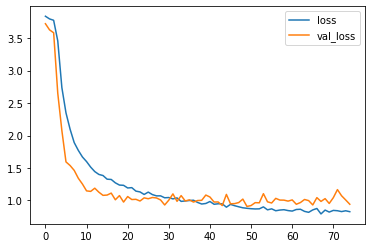

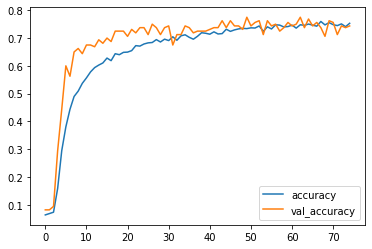

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
test_imgs = []
names = []
for dirname, _, filenames in os.walk(TEST_IMG_DIR):
    for filename in filenames:
        test_imgs.append(os.path.join(dirname, filename))
        names.append(os.path.splitext(filename)[0])
test_imgs = np.array(test_imgs)
names = np.array(names)

In [ ]:
test_data_img_list = []
for img_path in test_imgs:
    img = image.imread(img_path)
    data = np.asarray(img)
    if data.shape != (20,20,3):
        data = np.repeat(data[:, :, np.newaxis], 3, axis=2)
    data = data / 255.
    test_data_img_list.append(data)

test_data_img = np.asarray(test_data_img_list)

In [ ]:
pred = model.predict(test_data_img)

In [ ]:
test = []
res = []
for i in range(0, len(pred)):
    res.append(unique_labels[np.argmax(pred[i])])
    test.append(np.argmax(pred[i]))

In [ ]:
results = []
test = []
for i in range(0, len(pred)):
    results.append(unique_labels[np.argmax(pred[i])])
    test.append(np.argmax(pred[i]))

submission = pd.DataFrame(names, columns=['ID'])
submission['Class'] = results


In [ ]:
submission.head(20)

,ID,Class
0,7899,E
1,7466,e
2,6485,H
3,6911,I
4,8662,r
5,10930,a
6,12453,E
7,8057,I
8,12446,B
9,6679,T


In [ ]:
submission.to_csv('submission.csv', index = False)